In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import heapq
import itertools

In [2]:
# creat a maze
class Maze():
    def __init__(self, start):
        self.GRID_WIDTH = 6
        self.GRID_LENGTH = 9
        self.START = start
        self.GOAL = (0, 8)
        self.obstacles = [(1,2),(2,2),(3,2),(5,5),(0,7),(1,7),(2,7)]
        self.ACTIONS = [(-1,0), (1,0), (0,-1), (0,1)] # UP, DOWN, LEFT, RIGHT

    # @obstacle: a two-tuple
    def add_obstacle(self, obstacle):
        self.obstacles.append(obstacle)

    def remove_obstacle(self, obstacle):
        self.obstacles.remove(obstacle)

    def update_obstacles(self, obstacles):
        self.obstacles = obstacles

    def walk(self, state, action):
        i, j = state
        di, dj = self.ACTIONS[action]
        new_state = max(0, min(self.GRID_WIDTH-1, i+di)), max(0, min(self.GRID_LENGTH-1, j+dj))
        reward = 0
        if new_state in self.obstacles:
            new_state = state
        elif new_state == self.GOAL:
            reward = 1
        return reward, new_state


def choose_action(state, qtable, epsilon=0.1):
    i, j = state
    if np.random.random() < epsilon:
        action = np.random.randint(4)
    else:
        maxidx = [idx for idx in range(4) if qtable[i, j, idx] == max(qtable[i, j, :])]
        action = np.random.choice(maxidx)
    return action


# store the parameters
class DynaParams():
    def __init__(self):
        self.gamma = 0.95
        self.alpha = 0.1
        self.epsilon = 0.1
        self.kappa = 1e-4 # time weight
        self.planning_steps = 5
        self.episodes = 50


# Tabular Dyna-Q Algorithm
class DynaQModel():
    def __init__(self, params, start=(2,0)):
        self.maze = Maze(start)
        self.params = params
        self.model = {}
        self.qtable = np.zeros((self.maze.GRID_WIDTH, self.maze.GRID_LENGTH, 4)) # 4 actions

    def update(self, state, reward, action, new_state):
        i, j = state
        self.qtable[i, j, action] += self.params.alpha*(reward + \
            self.params.gamma*max(self.qtable[new_state[0], new_state[1], :]) - self.qtable[i, j, action])

    def feed(self, state, reward, action, new_state):
        if state not in self.model:
            self.model[state] = {}
        self.model[state][action] = [reward, new_state]

    def planning(self):
        states = list(self.model.keys())
        for i in range(self.params.planning_steps):
            idx = np.random.randint(len(states))
            old_state = states[idx]
            actions = list(self.model[old_state].keys())
            action = np.random.choice(actions)
            reward, next_state =self.model[old_state][action]
            self.update(old_state, reward, action, next_state)

    # @return: step number and total rewards after one episode
    def dyna_q(self):
        step_num = 0
        rewards = 0
        state = self.maze.START
        while state != self.maze.GOAL:
            action = choose_action(state, self.qtable)
            reward, new_state = self.maze.walk(state, action)
            self.update(state, reward, action, new_state)
            self.feed(state, reward, action, new_state)
            self.planning() 
            state = new_state
            rewards += reward
            step_num += 1

        return step_num, rewards


# Dyna-Q+
class DynaQPlusModel():
    def __init__(self, params, start=(5,3)):
        self.maze = Maze(start) # start state is (5,3)
        self.params = params
        self.model = {}
        self.time = 0
        self.qtable = np.zeros((self.maze.GRID_WIDTH, self.maze.GRID_LENGTH, 4)) # 4 actions

    def update(self, state, reward, action, new_state):
        i, j = state
        self.qtable[i, j, action] += self.params.alpha*(reward + \
            self.params.gamma*max(self.qtable[new_state[0], new_state[1], :]) - self.qtable[i, j, action])

    def feed(self, state, reward, action, new_state):
        self.time += 1
        if state not in self.model:
            self.model[state] = {}
            for action_ in range(4):
                if action_ != action:
                    self.model[state][action_] = [0, state, 1] # initialize
        self.model[state][action] = [reward, new_state, self.time]

    def planning(self):
        states = list(self.model.keys())
        for i in range(self.params.planning_steps):
            idx = np.random.randint(len(states))
            state = states[idx]
            actions = list(self.model[state].keys())
            action = np.random.choice(actions)
            reward, next_state, time = self.model[state][action]
            reward += self.params.kappa*np.sqrt(self.time - time)
            self.update(state, reward, action, next_state)

100%|██████████████████████████████████████████| 30/30 [01:38<00:00,  2.96s/it]


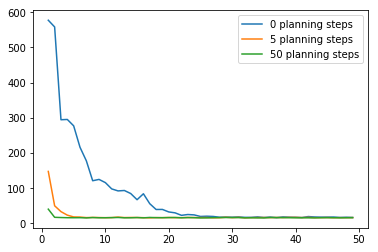

In [3]:
## Figure 8.2: different planning steps
params = DynaParams()
planning_steps = [0, 5, 50]
runs = 30
steps = np.zeros((len(planning_steps), params.episodes))

for i in tqdm(range(runs)):
    for k in range(len(planning_steps)):
        params.planning_steps = planning_steps[k]
        model = DynaQModel(params)
        for episode in range(params.episodes):
            step, _ = model.dyna_q()
            steps[k, episode] += step

steps /= runs
for k in range(len(planning_steps)):
    plt.plot(range(1, params.episodes), steps[k, 1:], label=f'{planning_steps[k]} planning steps')
plt.legend()

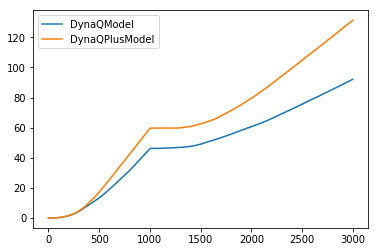

In [4]:
## changing maze in Figure 8.4 
params = DynaParams()
params.planning_steps = 10
params.alpha = 1
time_steps = 3000
time_changing = 1000
runs = 20
models = [DynaQModel, DynaQPlusModel]
cum_rewards = np.zeros((len(models), time_steps))
obstacles = [(3, j) for j in range(8)]

for m in range(len(models)):
    for run in range(runs):
        model = models[m](params, (5,3))
        model.maze.update_obstacles(obstacles.copy())
        state = model.maze.START
        for time_step in range(time_steps):
            action = choose_action(state, model.qtable)
            reward, new_state = model.maze.walk(state, action)
            model.update(state, reward, action, new_state)
            model.feed(state, reward, action, new_state)
            if new_state == model.maze.GOAL:
                state = model.maze.START
            else:
                state = new_state
            cum_rewards[m, time_step] += reward
            model.planning()                                #improve the q_table
            if time_step == time_changing - 1:
                model.maze.remove_obstacle((3,0))
                model.maze.add_obstacle((3,8))

    cum_rewards[m, :] = np.cumsum(cum_rewards[m, :])/runs
    plt.plot(range(time_steps), cum_rewards[m, :], label=model.__class__.__name__)
    
plt.legend()
plt.show()

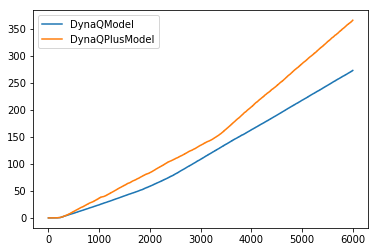

In [5]:
## Figure 8.5
params = DynaParams()
params.planning_steps = 50
params.alpha = 1
time_steps = 6000
time_changing = 3000
runs = 5
models = [DynaQModel, DynaQPlusModel]
cum_rewards = np.zeros((len(models), time_steps))
obstacles = [(3, j) for j in range(1, 9)]

for m in range(len(models)):
    for run in range(runs):
        model = models[m](params, (5,3))
        model.params.kappa = 1e-3
        model.maze.update_obstacles(obstacles.copy())
        state = model.maze.START
        for time_step in range(time_steps):
            action = choose_action(state, model.qtable)
            reward, new_state = model.maze.walk(state, action)
            model.update(state, reward, action, new_state)
            model.feed(state, reward, action, new_state)
            if new_state == model.maze.GOAL:
                state = model.maze.START
            else:
                state = new_state
            cum_rewards[m, time_step] += reward
            model.planning()
            if time_step == time_changing - 1:
                model.maze.remove_obstacle((3,8))
                
    cum_rewards[m, :] = np.cumsum(cum_rewards[m, :])/runs
    plt.plot(range(time_steps), cum_rewards[m, :], label=model.__class__.__name__)
    
plt.legend()
plt.show()